# IML - Model classification - CNNs

Best ANN trained was capable of ~94% accuracy and ~0.13 loss. Still we hit underfitting, 
time for cnn.

In [1]:
import os
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
from numpy.lib import stride_tricks
from datetime import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.api.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives,\
                              FalseNegatives, AUC, F1Score
from keras.api.optimizers import SGD, Adam


DATA_PATH = os.path.join(os.getcwd(), "..", "data")
DS_PATH = os.path.join(DATA_PATH, "overlap_000_res_256xwhole", "train")
LOG_DIR = os.path.join(os.getcwd(), "..", "logs")

2024-11-19 12:58:58.612426: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 12:58:58.629837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732017538.646119   24443 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732017538.650648   24443 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 12:58:58.672428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def overlapping_frames2D(X: np.ndarray, frame_size: int, overlap_factor: float) -> np.ndarray:
    assert len(X.shape) == 2, "X is not a 2D matrix."
    height, width = X.shape
    assert width >= frame_size, f"Frame size ({frame_size}) exceeds length of x ({width})."

    assert overlap_factor >= 0.0 and overlap_factor < 1.0,\
        f"Overlap factor ({overlap_factor}) has to be from range [0.0, 1.0)."

    stride_size = int(frame_size - np.floor(frame_size * overlap_factor))
    # Remove offset from the beginning of the data, its just background noise
    offset = (width - frame_size) % stride_size
    X = X[:, offset:]
    height, width = X.shape
    window_count = (width - frame_size) // stride_size + 1

    stride_height, stride_width = X.strides
    frames = stride_tricks.as_strided(X, shape=(window_count, height, frame_size),
                                      strides=(stride_width*stride_size, stride_height, stride_width))

    return frames



def load_data(ds_path: str = DS_PATH) -> tuple[np.ndarray, np.ndarray]:
    height, width = (128, 2048)
    X_paths = []
    y_arr = []

    for label in os.listdir(ds_path):
        for (dir_path, _, file_names) in os.walk(os.path.join(ds_path, label)):
            X_paths_cur = [os.path.join(dir_path, f) for f in file_names]
            y_cur = np.repeat(int(label), len(X_paths_cur))

            X_paths.extend(X_paths_cur)
            y_arr.append(y_cur)

    target_width = 128
    # Overlap factor = 0.52 cause it produces batch of 32 frames
    X_arr = [overlapping_frames2D(np.array(PIL.Image.open(path).convert('L').resize((width, height))),
                                  target_width,
                                  0.0)
            for path in X_paths]
    batch_size = X_arr[0].shape[0]

    return np.concatenate(X_arr, dtype=np.float32), np.repeat(np.concatenate(y_arr, dtype=np.float32), batch_size).reshape(-1, 1)

In [3]:
X, y = load_data(os.path.join(DATA_PATH, "overlap_000_res_256xwhole", "train"))

In [2]:
X = np.load(os.path.join(DATA_PATH, "numpy_res_128_128", "X.npy"))
y = np.load(os.path.join(DATA_PATH, "numpy_res_128_128", "y.npy"))

In [3]:
print(X.shape)
print(y.shape)

(24000, 128, 128)
(24000, 1)


In [4]:
print(X.dtype, y.dtype)

float32 uint8


In [5]:
y = y.astype(np.float32)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(15360, 128, 128) (15360, 1)
(3840, 128, 128) (3840, 1)
(4800, 128, 128) (4800, 1)


In [13]:
X_train.dtype

dtype('float32')

In [10]:
def first_cnn(input_shape = (256, 256)) -> keras.Model:
    inputs = keras.layers.Input(shape=input_shape, batch_size=32)
    # Preprocessing
    x = keras.layers.Reshape((*input_shape, 1))(inputs)
    x = keras.layers.Rescaling(scale=1.0/255, offset=0.0)(x)

    # Convolution layers
    x = keras.layers.Conv2D(4, kernel_size=(2, 2), strides=(1, 1))(x)
    x = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = keras.layers.Conv2D(4, kernel_size=(2, 2), strides=(1, 1))(x)
    x = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = keras.layers.Conv2D(4, kernel_size=(2, 2), strides=(1, 1))(x)
    x = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Dense layer
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="FirstCnn")


model = first_cnn((128, 128))
model.compile(optimizer="sgd", loss="binary_crossentropy",
              metrics=[BinaryAccuracy(), TruePositives(), TrueNegatives(), FalsePositives(),
                       FalseNegatives(), AUC(curve="PR"), AUC(curve="PR", from_logits=True, name="auc_from_logits"),
                       F1Score()])
model.summary()

I0000 00:00:1731950481.912654     823 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "FirstCnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (32, 128, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (32, 128, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (32, 128, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 127, 127, 4)      │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 63, 63, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 62, 62, 4)        │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 31, 31, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 30, 30, 4)        │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 15, 15, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 900)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 256)              │       230,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,069 (902.61 KB)

 Trainable params: 231,069 (902.61 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def generate_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

ds_train = generate_dataset(X_train, y_train)
ds_val = generate_dataset(X_val, y_val)

In [20]:
for data, label in ds_train.take(10):
    print(data, label)

tf.Tensor(
[[[ 35.  37.  33. ...  57.  38.  38.]
  [ 43.  48.  41. ...  93.  78.  78.]
  [142. 103. 109. ... 198. 190. 202.]
  ...
  [ 29.  29.  29. ...  29.  29.  29.]
  [ 29.  29.  29. ...  29.  29.  29.]
  [ 29.  29.  29. ...  29.  29.  29.]]

 [[ 50.  53.  38. ...  33.  35.  38.]
  [ 78.  83.  69. ...  40.  50.  65.]
  [131. 123. 133. ...  89. 104. 125.]
  ...
  [ 29.  29.  29. ...  29.  29.  29.]
  [ 29.  29.  29. ...  29.  29.  29.]
  [ 29.  29.  29. ...  29.  29.  29.]]

 [[102.  48. 140. ...  39.  27.  29.]
  [117.  90. 104. ... 130.  64.  31.]
  [218. 155. 154. ... 230. 143.  50.]
  ...
  [ 50.  40.  28. ...  29.  29.  29.]
  [ 36.  33.  29. ...  29.  29.  29.]
  [ 29.  29.  29. ...  29.  29.  29.]]

 ...

 [[ 27.  27.  38. ...  31.  28.  28.]
  [ 42.  42.  58. ...  47.  60.  49.]
  [103. 103. 113. ... 106. 134. 129.]
  ...
  [ 29.  29.  29. ...  29.  29.  29.]
  [ 29.  29.  29. ...  29.  29.  29.]
  [ 29.  29.  29. ...  29.  29.  29.]]

 [[ 42.  42.  43. ...  36.  37.  35.]
 

2024-11-18 17:00:43.157412: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
log_dir = os.path.join(LOG_DIR, "cnn")
model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S-{model.name}"))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)

history = model.fit(ds_train, validation_data=ds_val, batch_size=32, epochs=10,
                    callbacks=[tensorboard_cb])

Epoch 1/10


I0000 00:00:1731950497.515807    1730 service.cc:148] XLA service 0x7f6b9400abe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731950497.516157    1730 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-18 18:21:37.570001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731950497.662825    1730 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-18 18:21:38.357317: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_742', 4 bytes spill stores, 4 bytes spill loads



 18/480 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - auc: 0.3343 - auc_from_logits: 0.3320 - binary_accuracy: 0.5366 - f1_score: 0.4761 - false_negatives: 74.4444 - false_positives: 50.6111 - loss: 0.6772 - true_negatives: 158.0556 - true_positives: 20.8889

I0000 00:00:1731950500.274077    1730 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


480/480 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - auc: 0.3567 - auc_from_logits: 0.3556 - binary_accuracy: 0.6853 - f1_score: 0.4644 - false_negatives: 2297.7339 - false_positives: 54.6486 - loss: 0.6100 - true_negatives: 5336.6299 - true_positives: 22.9210 - val_auc: 0.4649 - val_auc_from_logits: 0.4640 - val_binary_accuracy: 0.7021 - val_f1_score: 0.4591 - val_false_negatives: 1140.0000 - val_false_positives: 4.0000 - val_loss: 0.5816 - val_true_negatives: 2692.0000 - val_true_positives: 4.0000
Epoch 2/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - auc: 0.4757 - auc_from_logits: 0.4756 - binary_accuracy: 0.7054 - f1_score: 0.4644 - false_negatives: 2167.1309 - false_positives: 77.2557 - loss: 0.5753 - true_negatives: 5314.0229 - true_positives: 153.5239 - val_auc: 0.5525 - val_auc_from_logits: 0.5506 - val_binary_accuracy: 0.7299 - val_f1_score: 0.4591 - val_false_negatives: 926.0000 - val_false_positives: 111.0000 - val_loss: 0.5459 - val_true_negatives: 2585.0000 - val_true_positives: 218

In [13]:
model = first_cnn((128, 128))
model.compile(optimizer="sgd", loss="binary_crossentropy",
              metrics=[BinaryAccuracy(), TruePositives(), TrueNegatives(), FalsePositives(),
                       FalseNegatives(), AUC(curve="PR"), AUC(curve="PR", from_logits=True, name="auc_from_logits"),
                       F1Score()])
log_dir = os.path.join(LOG_DIR, "cnn")
model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S-{model.name}"))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)

history = model.fit(ds_train, validation_data=ds_val, batch_size=32, epochs=50,
                    callbacks=[tensorboard_cb])

Epoch 1/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - auc_1: 0.4028 - auc_from_logits: 0.4005 - binary_accuracy: 0.6989 - f1_score: 0.4644 - false_negatives_1: 2310.9292 - false_positives_1: 2.0956 - loss: 0.5996 - true_negatives_1: 5389.1831 - true_positives_1: 9.7256 - val_auc_1: 0.5051 - val_auc_from_logits: 0.5047 - val_binary_accuracy: 0.7128 - val_f1_score: 0.4591 - val_false_negatives_1: 1098.0000 - val_false_positives_1: 5.0000 - val_loss: 0.5747 - val_true_negatives_1: 2691.0000 - val_true_positives_1: 46.0000
Epoch 2/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - auc_1: 0.4942 - auc_from_logits: 0.4928 - binary_accuracy: 0.7096 - f1_score: 0.4644 - false_negatives_1: 2107.6382 - false_positives_1: 102.8649 - loss: 0.5692 - true_negatives_1: 5288.4136 - true_positives_1: 213.0166 - val_auc_1: 0.6056 - val_auc_from_logits: 0.6057 - val_binary_accuracy: 0.7404 - val_f1_score: 0.4591 - val_false_negatives_1: 917.0000 - val_false_positives_1: 80.0000 - val_loss: 0.5283 - val_true_

In [ ]:
print(ds_train.cardinality(), ds_val.cardinality())

tf.Tensor(480, shape=(), dtype=int64) tf.Tensor(120, shape=(), dtype=int64)


In [ ]:
metrics=[BinaryAccuracy(), TruePositives(), TrueNegatives(), FalsePositives(),
                       FalseNegatives(), AUC(curve="PR"), AUC(curve="PR", from_logits=True, name="auc_from_logits"),
                       F1Score()]

On numpy arrays

In [ ]:
model2 = first_cnn((128, 128))
metrics=[BinaryAccuracy(), TruePositives(), TrueNegatives(), FalsePositives(),
                       FalseNegatives(), AUC(curve="PR"), AUC(curve="PR", from_logits=True, name="auc_from_logits"),
                       F1Score()]
model2.compile(optimizer="sgd", loss="binary_crossentropy",
              )
log_dir = os.path.join(LOG_DIR, "cnn")
model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S-{model2.name}"))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)

history = model2.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=50,
                    callbacks=[tensorboard_cb])

Epoch 1/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - auc_2: 0.3799 - auc_from_logits: 0.3780 - binary_accuracy: 0.7010 - f1_score: 0.4603 - false_negatives_2: 2294.6404 - false_positives_2: 1.3763 - loss: 0.5981 - true_negatives_2: 5412.8110 - true_positives_2: 3.1060 - val_auc_2: 0.4802 - val_auc_from_logits: 0.4796 - val_binary_accuracy: 0.7052 - val_f1_score: 0.4591 - val_false_negatives_2: 1132.0000 - val_false_positives_2: 0.0000e+00 - val_loss: 0.5728 - val_true_negatives_2: 2696.0000 - val_true_positives_2: 12.0000
Epoch 2/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc_2: 0.4687 - auc_from_logits: 0.4677 - binary_accuracy: 0.7148 - f1_score: 0.4573 - false_negatives_2: 2078.8462 - false_positives_2: 111.6029 - loss: 0.5700 - true_negatives_2: 5311.8130 - true_positives_2: 209.6715 - val_auc_2: 0.5869 - val_auc_from_logits: 0.5855 - val_binary_accuracy: 0.7190 - val_f1_score: 0.4591 - val_false_negatives_2: 499.0000 - val_false_positives_2: 580.0000 - val_loss: 0.5674 - val_

In [17]:
model2.save("../models/firstcnn.keras", zipped=True)

In [7]:
model2 = keras.models.load_model("../models/firstcnn.keras")

I0000 00:00:1732012755.033803     902 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
y_test_prob = model2.predict(X_test, batch_size=32)

I0000 00:00:1732012793.490675    2447 service.cc:148] XLA service 0x7f6fb4006a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732012793.490954    2447 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-19 11:39:53.507373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732012793.531804    2447 cuda_dnn.cc:529] Loaded cuDNN version 90300


 79/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1732012794.381950    2447 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [15]:
y_test_pred = y_test_prob >= 0.5

In [16]:
confusion_matrix(y_test, y_test_pred)

array([[3307,   50],
       [  49, 1394]])

In [17]:
wrong_predictions = np.arange(len(y_test))[(y_test_pred != y_test).reshape(-1)]

In [18]:
wrong_predictions

array([ 120,  151,  219,  225,  385,  443,  445,  594,  680,  714,  726,
        727,  770,  808,  907,  970,  996, 1028, 1043, 1068, 1124, 1196,
       1197, 1273, 1293, 1299, 1362, 1367, 1399, 1449, 1486, 1506, 1517,
       1541, 1593, 1643, 1647, 1702, 1730, 1782, 1856, 1938, 2037, 2142,
       2151, 2205, 2214, 2390, 2413, 2495, 2521, 2557, 2583, 2637, 2652,
       2699, 2731, 2853, 2890, 2955, 2977, 3007, 3110, 3226, 3265, 3317,
       3374, 3375, 3547, 3598, 3628, 3674, 3699, 3747, 3763, 3794, 3944,
       4016, 4047, 4061, 4082, 4109, 4129, 4192, 4195, 4211, 4290, 4437,
       4461, 4512, 4562, 4580, 4644, 4662, 4709, 4713, 4726, 4742, 4782])

In [80]:
def logistic_regression_loss(y_true: np.ndarray, y_pred: np.ndarray, per_sample = True):
    eps = 1e-8
    loss = y_true * np.log(y_pred + eps) + (1.0 - y_true) * np.log(1.0 - y_pred + eps)
    if per_sample:
        return -loss
    else:
        return np.sum(-loss)

sample_losses = logistic_regression_loss(y_test, y_test_prob)

In [81]:
loss_idx_sorted = np.argsort(-sample_losses.reshape(-1))
loss_idx_sorted[:10]

array([4061, 3794, 1449, 3110, 1506, 1124, 2699, 3674, 2557,  151])

[1] [False] [0.000562]


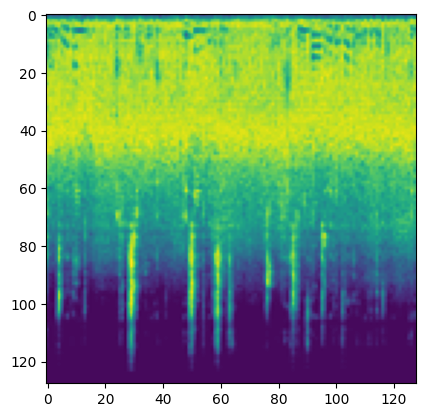

In [78]:
idx = 3674
print(y_test[idx], y_test_pred[idx], y_test_prob[idx])
plt.imshow(X_test[idx])
plt.show()

In [15]:
def cnn_activations_pooling(input_shape = (128, 128)) -> keras.Model:
    inputs = keras.layers.Input(shape=input_shape, batch_size=32)

    # Preprocessing
    x = keras.layers.Reshape((*input_shape, 1))(inputs)
    x = keras.layers.Rescaling(scale=1.0/255, offset=0.0)(x)

    # Convolution layers
    x = keras.layers.Conv2D(16, kernel_size=(2, 2), strides=(1, 1), activation="relu")(x)
    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = keras.layers.Conv2D(64, kernel_size=(2, 2), strides=(1, 1), activation="relu")(x)
    x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = keras.layers.Conv2D(128, kernel_size=(2, 2), strides=(1, 1), activation="relu")(x)
    # x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = keras.layers.AvgPool2D(pool_size=(2, 2))(x)

    # Dense layer
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="CnnActivationsPooling_filters_16_64_128")


metrics = [BinaryAccuracy(), TruePositives(), TrueNegatives(), FalsePositives(),
                       FalseNegatives(), AUC(curve="PR"), AUC(curve="PR", from_logits=True, name="auc_from_logits"),
                       F1Score()]
model = cnn_activations_pooling()
model.compile(optimizer="sgd", loss="binary_crossentropy",
              metrics=metrics)
model.summary()
log_dir = os.path.join(LOG_DIR, "cnn")
model_log_dir = os.path.join(log_dir, datetime.now().strftime(f"%Y%m%d-%H%M%S-{model.name}"))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=50,
                    callbacks=[tensorboard_cb])

Model: "CnnActivationsPooling_filters_16_64_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (32, 128, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (32, 128, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (32, 128, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 127, 127, 16)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 63, 63, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 62, 62, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 31, 31, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 30, 30, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (32, 15, 15, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (32, 28800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 256)              │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 1)                │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,410,449 (28.27 MB)

 Trainable params: 7,410,449 (28.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - auc_4: 0.3484 - auc_from_logits: 0.3445 - binary_accuracy: 0.6946 - f1_score: 0.4605 - false_negatives_4: 2302.1870 - false_positives_4: 33.9730 - loss: 0.6101 - true_negatives_4: 5356.7900 - true_positives_4: 18.9834 - val_auc_4: 0.4528 - val_auc_from_logits: 0.4516 - val_binary_accuracy: 0.7021 - val_f1_score: 0.4591 - val_false_negatives_4: 1144.0000 - val_false_positives_4: 0.0000e+00 - val_loss: 0.5866 - val_true_negatives_4: 2696.0000 - val_true_positives_4: 0.0000e+00
Epoch 2/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - auc_4: 0.4712 - auc_from_logits: 0.4691 - binary_accuracy: 0.6950 - f1_score: 0.4688 - false_negatives_4: 2307.2058 - false_positives_4: 9.3701 - loss: 0.5868 - true_negatives_4: 5370.8628 - true_positives_4: 24.4948 - val_auc_4: 0.5308 - val_auc_from_logits: 0.5293 - val_binary_accuracy: 0.7292 - val_f1_score: 0.4591 - val_false_negatives_4: 974.0000 - val_false_positives_4: 66.0000 - val_loss: 0.5592 - v

In [ ]:
learning_rates = np.logspace(-3, -2, 3)
for learning_rate in learning_rates:
    optimizer = SGD

array([0.001     , 0.00316228, 0.01      ])